## Dam modelling
Task is to do a synthetic modelling of an embankment dyke with the following sketch:
![DamSketch](sketch.png)
It consists of an inner core (A), an outer core of two materials (B+C), and a main body D.
On the upstream side (U.S.) there is a water table, on the downstream side (N.S.) not.
Due to the water, the material of B+C+D will be different on US from NS.
We are now building this model from the scratch using pyGIMLi.

In [1]:
# First import the numpy (numerics) pygimli libraries
import numpy as np
import pygimli as pg

In [2]:
# definition of some measures
hWT = 3  # height of the water table
hD = 4  # height of the crest (D)
thickD = 0.4  # thickness of D layer
thickB = 0.1  # thickness of B layer
wAtop = 1.1  # width of A on top (before 2.1)
wAbot = 1.6  # width of A at bottom (before 2.6)
wBtop = 0.4  # width of B on top
wBbot = 0.5  # width of B at bottom
wCtop = 0.5  # width of C on top
wCbot = 0.9  # width of A at bottom
wDtop = 4  # width of the crest (D) on top
wDbot = 15  # width of the crest (D) at the bottom (before 16)
distW = 5  # distance for water region at the bottom

In [3]:
# related measures
hBC = hD - thickD  # height of B and C
hA = hBC - thickB  # height of A (core)
xAB = wAbot / 2  # AB change
xBC = xAB + wBbot  # BC change
xCD = xBC + wCbot  # CD change
xD = wDbot / 2  # D change
xABtop = wAtop / 2  # AB change on top
xBCtop = xABtop + wBtop  # BC change on top
xCDtop = xBCtop + wCtop  # CD change on top
# create bottom line of points (left edge, intersections) and connect them
xBot = [-xD-distW, -xD, -xCD, -xBC, -xAB, xAB, xBC, xCD, xD]

In [4]:
# start creating a 2D PLC as basis for 3D and for plotting
plc = pg.Mesh(2)  # create empty 2D mesh
nBot = [plc.createNode([xx, 0]) for xx in xBot]
for i in range(len(nBot)-1):
    plc.createEdge(nBot[i], nBot[i+1], -1)  # Neumann


In [5]:
# A definition for cutting the water table
def xCutWT(xTop, xBottom, hTop, hWT):
    """compute the intersection point of a horizontal with subvertical line."""
    return xBottom - (xBottom - xTop) * hWT / hTop

(<matplotlib.axes._subplots.AxesSubplot at 0x20edc252080>, None)

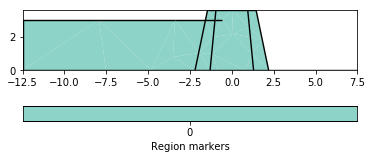

In [6]:
# create two points defining the water layer and connect to left point
nWTLeft = plc.createNode([-xD-distW, hWT])  # left water table
plc.createEdge(nBot[0], nWTLeft, -1)  # bottom-up
nWTD = plc.createNode([-xCutWT(wDtop/2, wDbot/2, hD, hWT), hWT])  # cut D
plc.createEdge(nWTLeft, nWTD, -1)
xCutC = -xCutWT(wAtop/2+wBtop+wCtop, wAbot/2+wBbot+wCbot, hBC, hWT)  # cut C
nWTC = plc.createNode([xCutC, hWT])
plc.createEdge(nWTD, nWTC, -1)
xCutB = -xCutWT(wAtop/2+wBtop, wAbot/2+wBbot, hBC, hWT)  # cut B
nWTB = plc.createNode([xCutB, hWT])
plc.createEdge(nWTC, nWTB, -1)
nWTA = plc.createNode([-xCutWT(wAtop/2, wAbot/2, hA, hWT), hWT])  # cut A
plc.createEdge(nWTB, nWTA, -1)
# create line of points on B/C height and connect them
xBC = [-xCDtop, -xBCtop, 0, xBCtop, xCDtop]
nBC = [plc.createNode([xx, hBC]) for xx in xBC]
for i in range(len(nBC)-1):
    plc.createEdge(nBC[i], nBC[i+1], 1)
# connect points from both lines by vertical lines
plc.createEdge(nBot[2], nWTC, 1)  # interface between D and C
plc.createEdge(nWTC, nBC[0], 1)
plc.createEdge(nBot[3], nWTB, 1)  # interface between C and B
plc.createEdge(nWTB, nBC[1], 1)
plc.createEdge(nBot[6], nBC[3], 1)
plc.createEdge(nBot[7], nBC[4], 1)
pg.show(plc)

(<matplotlib.axes._subplots.AxesSubplot at 0x20edc59ae80>, None)

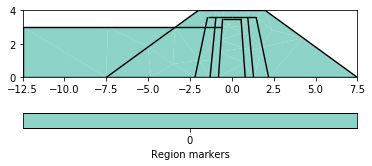

In [7]:
# create upper edges of core (A) and connect to core foot
nALeft = plc.createNode([-xABtop, hA])
nARight = plc.createNode([xABtop, hA])
plc.createEdge(nALeft, nARight, 1)
plc.createEdge(nBot[4], nWTA, 1)
plc.createEdge(nWTA, nALeft, 1)
plc.createEdge(nBot[5], nARight, 1)
# create upper crest points and connect to dam foot
nCrestLeft = plc.createNode([-wDtop / 2, hD])
nCrestRight = plc.createNode([wDtop / 2, hD])
plc.createEdge(nCrestLeft, nCrestRight, -2)
plc.createEdge(nBot[1], nWTD, 1)
plc.createEdge(nWTD, nCrestLeft, 1)
plc.createEdge(nBot[-1], nCrestRight, 1)
pg.show(plc)

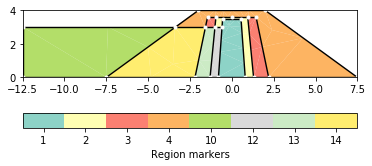

In [10]:
# add region markers to define the materials (A-D=1-4) dry and wet (+10)
plc.addRegionMarker([0.1, 0.1], 1)  # A=1
plc.addRegionMarker([xBCtop-0.01, hBC-0.01], 2)  # B above WT
plc.addRegionMarker([-xBCtop-0.1, hBC-0.1], 3)  # C above WT U.S. = 2
plc.addRegionMarker([xBCtop+0.1, hBC-0.1], 3)  # C above WT D.S. = 3
plc.addRegionMarker([xCDtop+0.1, hBC-0.1], 4)  # D above WT = 4
plc.addRegionMarker([-xD-0.1, 0.1], 10)  # water=10
plc.addRegionMarker([-xBCtop-0.01, hWT-0.01], 12)  # B below WT = 12
plc.addRegionMarker([-xBCtop-0.1, hWT-0.1], 13)  # C below WT U.S. =13
plc.addRegionMarker([-xD+0.3, 0.1], 14)  # D below WT = 14
ax, _ = pg.show(plc)
ax.plot(pg.x(plc), pg.y(plc), 'w.')  # show nodes with white dot

(<matplotlib.axes._subplots.AxesSubplot at 0x20edcb87908>, None)

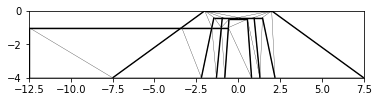

In [11]:
mesh2d = pg.meshtools.createMesh(plc, quality=0)  # just Delaunay
mesh2d.translate([0, -hD])  # so that zero is on top
pg.show(mesh2d)

In [12]:
# Now we bring the model from 2D into 3D by copying all facets and combining them
n2d = plc.nodeCount()  # number of nodes in 2d plc
plc3d = pg.Mesh(3)
nF = [plc3d.createNode([0, n.x(), n.y()]) for n in plc.nodes()]  # front
nB = [plc3d.createNode([20, n.x(), n.y()]) for n in plc.nodes()]  # back
edge = plc.boundary(0)
for edge in plc.boundaries():
    n1 = edge.node(0).id()
    n2 = edge.node(1).id()
    plc3d.createQuadrangleFace(nF[n1], nF[n2], nB[n2], nB[n1])
for tri in mesh2d.cells():
    plc3d.createTriangleFace(*[nF[n.id()] for n in tri.nodes()])
    plc3d.createTriangleFace(*[nB[n.id()] for n in tri.nodes()])
# copy every region marker into 3D mesh
for rm in plc.regionMarker():
    plc3d.addRegionMarker([0.1, rm.x(), rm.y()], marker=rm.marker())
# create electrode lines (on crest, edges, top of A)
eyz = [[0, hD-0.2], [0, hA-0.1]]
ex = np.arange(64) * 0.3 + 0.6  # 0.5m spaced electrodes
for yz in eyz:
    ne = [plc3d.createNode([x, yz[0], yz[1]], marker=-99) for x in ex]

yz = eyz[0]
E = np.column_stack((ex, np.ones_like(ex)*yz[0], np.ones_like(ex)*yz[1]))
np.savetxt('elec.xyz', E, fmt='%.2f')
# print and export 3D PLC
print(plc3d)
pg.meshtools.exportPLC(plc3d, 'dam3d.poly')
plc3d.exportVTK('dam3d-poly.vtk')

Mesh: Nodes: 174 Cells: 0 Boundaries: 93


Open the resulting file dam3d-poly.vtk in ParaView.

Now we go into the 3D mesh generator tetgen by calling on the command line
```
MESH=dam3d
tetgen -pazVAC -q 1.25 $MESH.poly
meshconvert -it -VDBM -o $MESH $MESH.1  # converts into .bms, .mesh, .vtk formats
```

Alternatively, we can call the mesh generator (version 1.5.1) multiple times:
```
for i in {1..8}; do
  tetgen151 -raQq$QUALITY $MESH.$i
done
meshconvert -it -VDBM -o $MESH $MESH.$[i + 1]
```
![ParaView-Screenshot](screenshot.png)